## Lung Segmentation using UNets

In [49]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import os, os.path as osp

import numpy as np
import imgaug.augmenters as iaa

from deeply.model.unet import (
    UNet,
    AttentionUNet,
    Trainer
)
from deeply.plots import segplot, history_plot
from deeply.datasets.util import split as split_dataset
from deeply.generators import ImageMaskGenerator

from deeply.util.system import makedirs

from deeply.util.image  import augment as augment_images

from deeply._compat import iteritems

import deeply.datasets as dd

import tqdm.notebook as tq

#### Constants

In [29]:
image_size    = (256, 256)
width, height = image_size
batch_size = 1

split_types = ("train", "val", "test")

#### Build Model

In [4]:
unet = UNet(x = width, y = height, n_classes = 1, final_activation = "sigmoid",
            batch_norm = False, padding = "same")

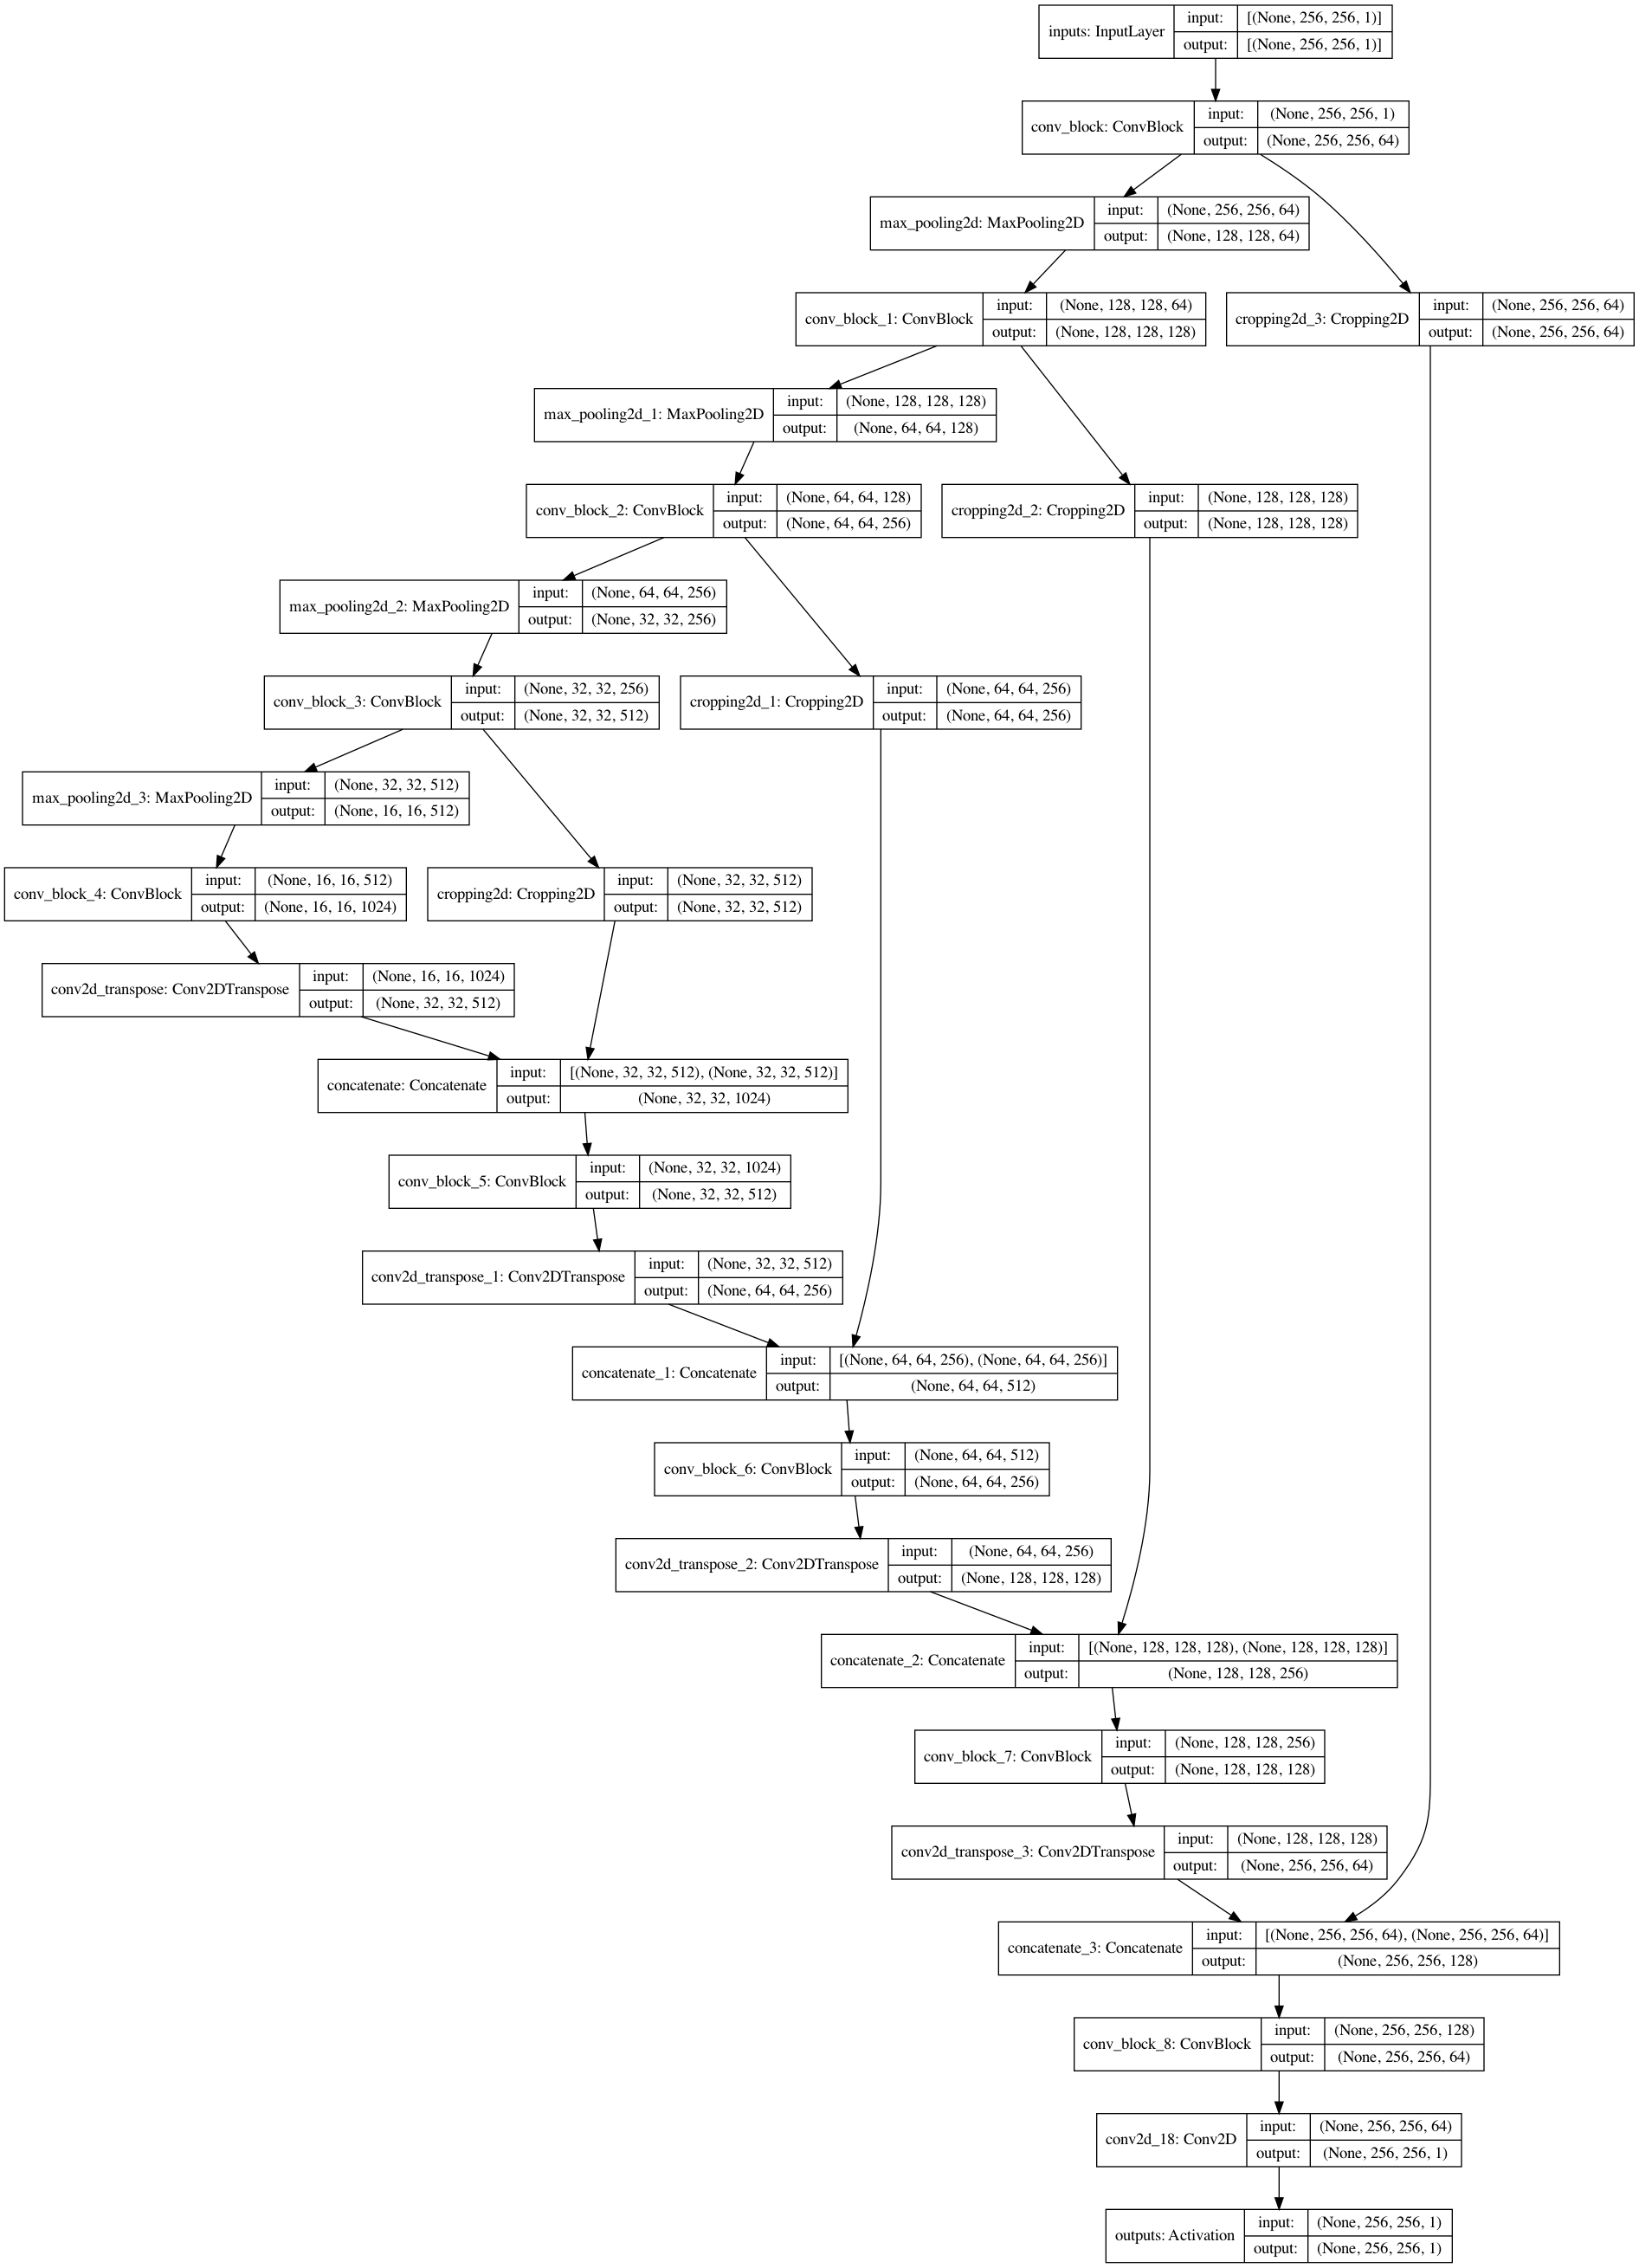

In [5]:
unet.plot()

In [6]:
output_shape = unet.output_shape[1:-1]

#### Prepare Dataset

In [7]:
!rm -rf ./data

In [8]:
names   = ("montgomery",)

image_augmentor = iaa.Sequential([
    iaa.Resize({ "width": width, "height": height }),
    iaa.CLAHE(
        from_colorspace = iaa.CLAHE.RGB,
        to_colorspace   = iaa.CLAHE.HSV
    )
])

mask_augmentor  = iaa.Sequential([
    iaa.Resize({ "width": output_shape[0], "height": output_shape[1] })
])

for name in names:
    dataset = split_dataset(dd.load(name, shuffle_files = True)["data"])
    groups  = dict(zip(split_types, dataset))
    
    for split_type, split in iteritems(groups):
        print("Generating %s images..." % split_type)
        
        dir_name = osp.join("data", split_type)
        makedirs(dir_name, exist_ok = True)

        for i, data in enumerate(tq.tqdm(split.batch(1))):
            augment_images(image_augmentor, images = data["image"].numpy(), filename = osp.join(dir_name, "images", "%s.jpg" % i))
            augment_images(mask_augmentor,  images = data["mask"].numpy(),  filename = osp.join(dir_name, "masks",  "%s.jpg" % i))

Generating train images...


  0%|          | 0/83 [00:00<?, ?it/s]

Generating val images...


  0%|          | 0/28 [00:00<?, ?it/s]

Generating test images...


  0%|          | 0/27 [00:00<?, ?it/s]

In [39]:
args = dict(batch_size = batch_size, color_mode = "grayscale", image_size = image_size, mask_size = output_shape, shuffle = True)
train, val, test = [ImageMaskGenerator("data/%s/images" % type_, "data/%s/masks" % type_, **args) for type_ in split_types]

#### Show Samples

In [10]:
from itertools import islice

In [11]:
n_samples = 3

In [12]:
samples = islice(test, n_samples)

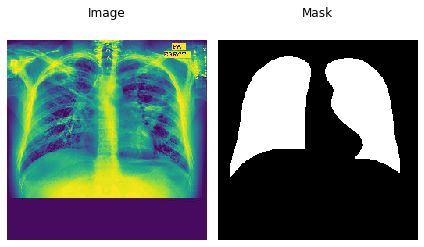

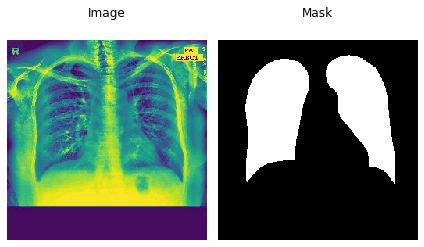

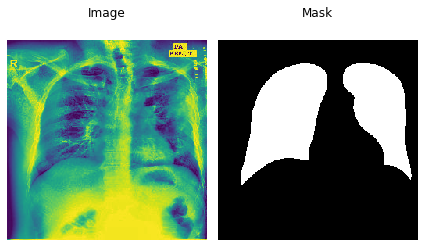

In [13]:
for image, mask in samples:
    segplot(image[0], mask[0])

In [14]:
from tensorflow.keras.optimizers import Adam

from deeply.losses import dice_loss

In [15]:
unet.compile(optimizer = Adam(learning_rate = 1e-5), loss = dice_loss, metrics = ["binary_accuracy"])

In [16]:
epochs = 10

#### Preprocess Data

In [17]:
trainer = Trainer()
history = trainer.fit(unet, train, val = val, epochs = epochs)

Epoch 1/10
83/83 [==============================] - 368s 4s/step - loss: 0.5604 - binary_accuracy: 0.3675 - dice_coefficient: 0.4396 - jaccard_index: 0.2859 - val_loss: 0.4195 - val_binary_accuracy: 0.8234 - val_dice_coefficient: 0.5805 - val_jaccard_index: 0.4125
Epoch 2/10
83/83 [==============================] - 349s 4s/step - loss: 0.2582 - binary_accuracy: 0.8896 - dice_coefficient: 0.7418 - jaccard_index: 0.5984 - val_loss: 0.1774 - val_binary_accuracy: 0.9219 - val_dice_coefficient: 0.8226 - val_jaccard_index: 0.7012
Epoch 3/10
83/83 [==============================] - 343s 4s/step - loss: 0.1585 - binary_accuracy: 0.9266 - dice_coefficient: 0.8415 - jaccard_index: 0.7297 - val_loss: 0.1372 - val_binary_accuracy: 0.9295 - val_dice_coefficient: 0.8628 - val_jaccard_index: 0.7609
Epoch 4/10
83/83 [==============================] - 360s 4s/step - loss: 0.1345 - binary_accuracy: 0.9380 - dice_coefficient: 0.8655 - jaccard_index: 0.7659 - val_loss: 0.1328 - val_binary_accuracy: 0.9395

(<Figure size 432x288 with 4 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'binary_accuracy'}>,
        <AxesSubplot:title={'center':'dice_coefficient'}>,
        <AxesSubplot:title={'center':'jaccard_index'}>], dtype=object))

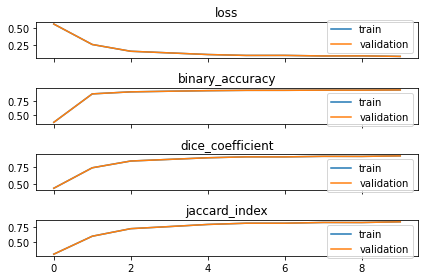

In [18]:
history_plot(unet.history)

In [40]:
_ = unet.evaluate(test)

27/27 [==============================] - 23s 864ms/step - loss: 0.0817 - binary_accuracy: 0.9645 - dice_coefficient: 0.9183 - jaccard_index: 0.8500


In [41]:
predict = unet.predict(test)

In [51]:
from deeply.metrics import jaccard_index, dice_coefficient

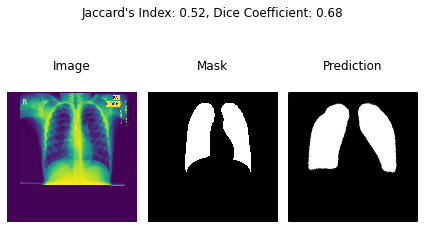

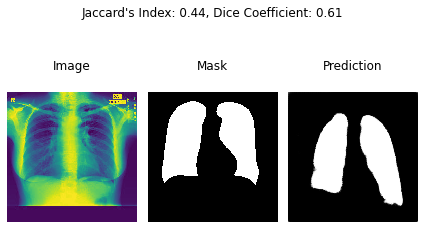

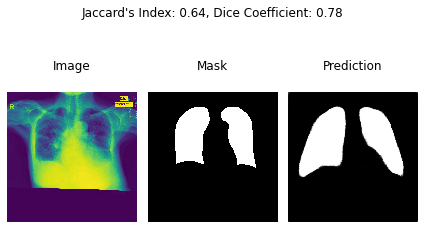

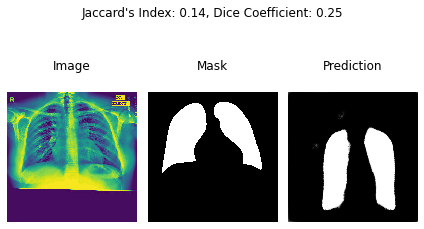

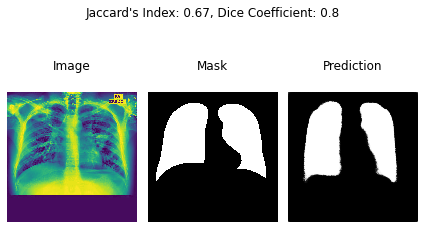

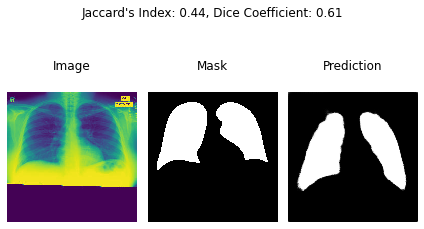

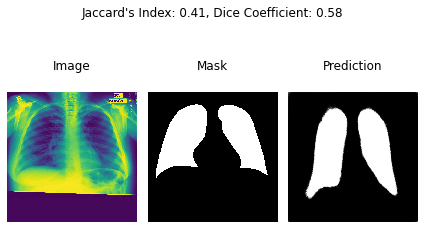

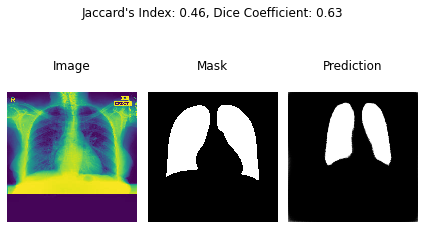

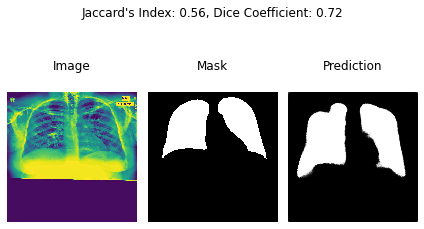

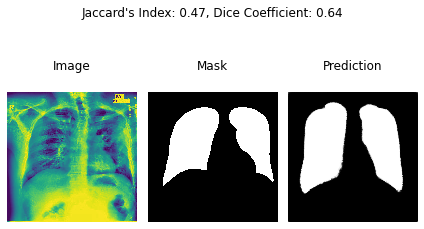

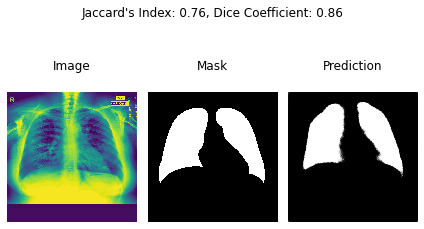

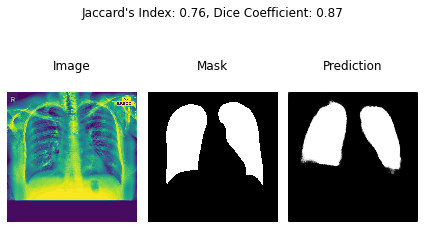

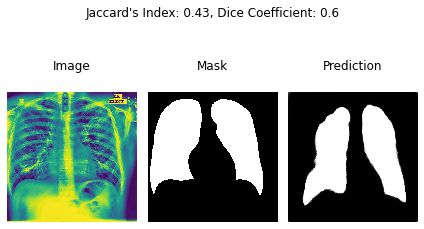

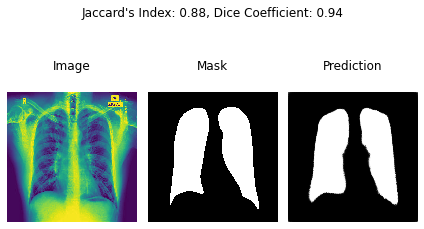

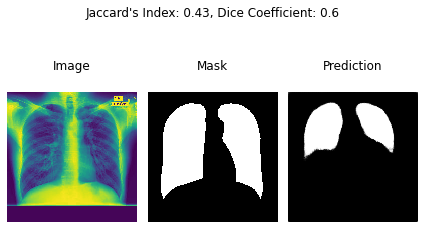

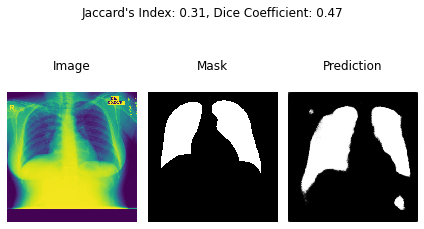

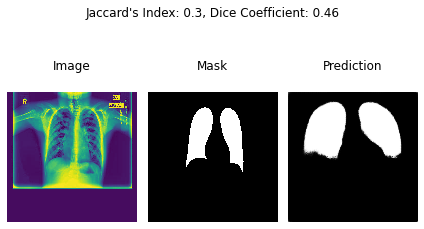

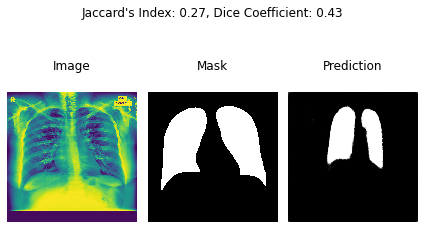

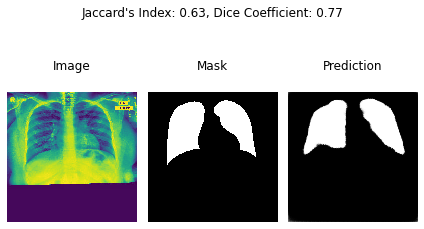

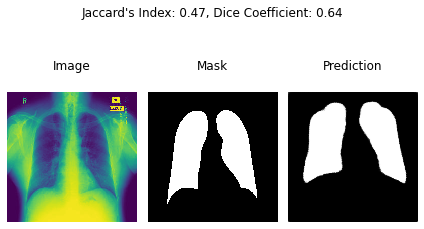

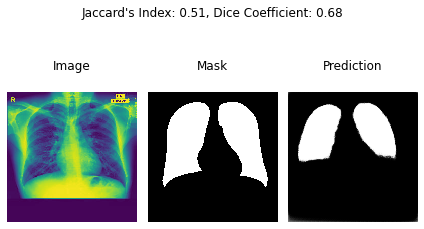

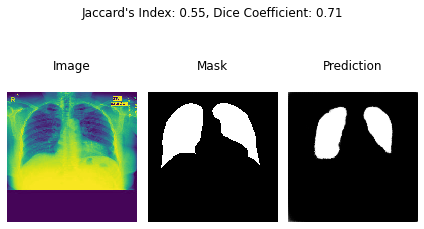

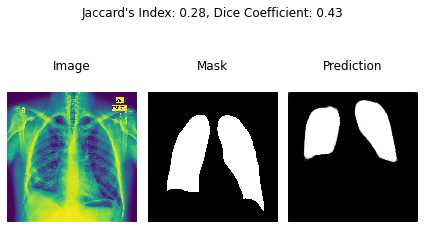

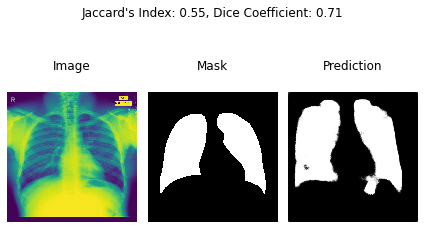

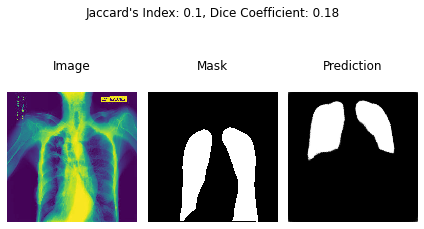

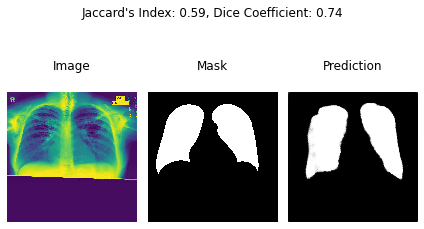

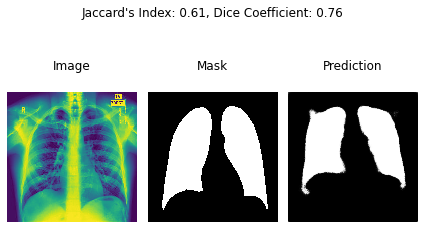

In [52]:
for i, (image, mask) in enumerate(test):
    jaccard = np.round(jaccard_index(mask[0], predict[i]).numpy(), 2)
    dice    = np.round(dice_coefficient(mask[0], predict[i]).numpy(), 2)
    
    title   = "Jaccard's Index: %s, Dice Coefficient: %s" % (jaccard, dice)
    
    segplot(image[0], mask[0], predict[i], super_title = title)